In [25]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from keras.optimizers import SGD,Adam
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, RNN, GRUCell, Dropout    
    
from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize.regexp import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.metrics import f1_score, make_scorer,accuracy_score,classification_report
import nltk
import re
from sklearn import svm
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import swifter

# set the max columns to none
pd.set_option('display.max_columns', None)

1 Physical GPUs, 1 Logical GPUs


In [26]:
MAXLEN = 600
NUM_WORDS = 70000
EMBEDDING_DIM = 200

In [2]:
"""
from google.colab import drive
drive.mount('/content/drive')
"""


Mounted at /content/drive


In [7]:
import configparser
import sys
sys.path.append('../src')
import Bibli_DataScience_3_3 as ds
config = configparser.ConfigParser()
config.read('../Rakuten_config.ini') 

section :  ['DOSSIER', 'FICHIER']


['../Rakuten_config.ini']

In [3]:
"""
df_feats= pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Rakuten/X_train_update.csv')
print(df_feats.info())
df_target= pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Rakuten/Y_train_CVw08PX.csv')
print(df_target.info())
nomenclature = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Rakuten/NOMENCLATURE.CSV',header=0,encoding='utf-8',sep=';',index_col=0)
Lcat=df_target.sort_values(by = ['prdtypecode'])['prdtypecode'].unique()
catdict=nomenclature.to_dict()['definition']
print(len(Lcat)," catégories")
for c in Lcat:
    print(c,"Catégorie ",catdict[c] )
stopwordFR = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Rakuten/stopwords_FR.csv")
"""

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   84916 non-null  int64 
 1   designation  84916 non-null  object
 2   description  55116 non-null  object
 3   productid    84916 non-null  int64 
 4   imageid      84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Unnamed: 0   84916 non-null  int64
 1   prdtypecode  84916 non-null  int64
dtypes: int64(2)
memory usage: 1.3 MB
None
27  catégories
10 Catégorie  livres
40 Catégorie  jeux video pour pc et consoles
50 Catégorie   accesoires jeux video
60 Catégorie  consoles de jeux video
1140 Catégorie  produits derives “geeks” et figurines
1160 Catégorie  cartes collect

In [9]:
"""
df_feats=pd.read_csv('X_train_update.csv')
df_target=pd.read_csv('Y_train_CVw08PX.csv')
df=df_feats.merge(df_target,on='Unnamed: 0',how='inner')
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)
Lcat=df_target.sort_values(by = ['prdtypecode'])['prdtypecode'].unique()
nomenclature=pd.read_csv('NOMENCLATURE.csv',header=0,encoding='utf-8',sep=';',index_col=0)
catdict=nomenclature.to_dict()['definition']
print(len(Lcat)," catégories")
#for c in Lcat:
#    print(c,"Catégorie ",catdict[c] )
stopwordFR = pd.read_csv("stopwords_FR.csv")
nltk.download('punkt')
"""

import pandas as pd

# lecture des données sources d'entrainement
df_feats=pd.read_csv(ds.get_RACINE_DOSSIER() + 'X_train_update.csv')

# lecture des données cibles d'entrainement
df_target=pd.read_csv(ds.get_RACINE_DOSSIER() + 'Y_train_CVw08PX.csv')


# création d'un dataframe globale -  jointure
df=df_feats.merge(df_target,on='Unnamed: 0',how='inner')
df.rename(columns={'Unnamed: 0': 'Id'}, inplace=True)

# récupération du fichier df_langue.csv
df_langue=pd.read_csv(ds.get_RACINE_DOSSIER() + 'df_langue.csv')
df=df.merge(df_langue.drop(['Unnamed: 0','prdtypecode'], axis=1),on='Id',how='inner')

Lcat=df_target.sort_values(by='prdtypecode')['prdtypecode'].unique()


nomenclature=pd.read_csv(ds.get_RACINE_DOSSIER() + 'NOMENCLATURE.csv',header=0,encoding='utf-8',sep=';',index_col=0)
catdict=nomenclature.to_dict()['definition']

#
stopwordFR = pd.read_csv(ds.get_RACINE_DOSSIER() + 'stopwords_FR_02.csv')
#nltk.download('punkt')



In [5]:
df_feats

,Unnamed: 0,designation,description,productid,imageid
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786
...,...,...,...,...,...
84911,84911,The Sims [ Import Anglais ],NaN,206719094,941495734
84912,84912,Kit piscine acier NEVADA déco pierre Ø 3.50m x...,<b>Description complète :</b><br />Kit piscine...,3065095706,1188462883
84913,84913,Journal Officiel De La Republique Francaise N°...,NaN,440707564,1009325617
84914,84914,Table Basse Bois De Récupération Massif Base B...,<p>Cette table basse a un design unique et con...,3942400296,1267353403


In [6]:
df_target

,Unnamed: 0,prdtypecode
0,0,10
1,1,2280
2,2,50
3,3,1280
4,4,2705
...,...,...
84911,84911,40
84912,84912,2583
84913,84913,2280
84914,84914,1560


In [30]:
df_feats['description'] = df_feats['description'].fillna(df_feats['designation'])

In [ ]:
pip install spacy
python -m spacy download en_core_web_sm  # pour l'anglais
python -m spacy download fr_core_news_sm  # pour le français
python -m spacy download es_core_news_sm  # pour l'espagnol


In [ ]:
import spacy
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from langdetect import detect
import string

# Chargement des modèles SpaCy
nlp_en = spacy.load('en_core_web_sm')
nlp_fr = spacy.load('fr_core_news_sm')
nlp_es = spacy.load('es_core_news_sm')

# Fonction pour sélectionner le modèle SpaCy en fonction de la langue détectée
def get_spacy_model(lang):
    if lang == 'fr':
        return nlp_fr
    elif lang == 'es':
        return nlp_es
    else:  # par défaut à l'anglais
        return nlp_en

# Exemple de données multilingues
texts = ["This is an example sentence.", "Voici une phrase exemple.", "Este es un ejemplo de frase."]

# Fonction pour nettoyer, tokeniser et appliquer la lemmatisation
def preprocess_text(text):
    # Détection de la langue
    try:
        lang = detect(text)
    except:
        lang = "en"  # Langue par défaut
    
    # Sélection du modèle SpaCy approprié
    nlp = get_spacy_model(lang)
    
    # Nettoyage du texte
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Lemmatisation avec SpaCy
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_space]
    
    return lemmatized_tokens

# Prétraitement des textes
tokenized_texts = [preprocess_text(text) for text in texts]

# Indexation des mots
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_texts)
sequences = tokenizer.texts_to_sequences(tokenized_texts)

# Padding des séquences
max_length = max(len(sequence) for sequence in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

print("Séquences tokenisées et lemmatisées :")
print(padded_sequences)




In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Paramètres du modèle
vocab_size = len(tokenizer.word_index) + 1  # Taille du vocabulaire
embedding_dim = 100  # Dimension de l'espace d'embedding
max_length = max_length  # Déjà calculé lors du prétraitement

# Construction du modèle
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Utilisez 'softmax' pour la classification multiclasse
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Ajustez selon votre tâche
model.summary()


In [ ]:
# Exemple simplifié d'entraînement
X_train = padded_sequences  # Vos séquences prétraitées
y_train = [0, 1, 0]  # Exemple d'étiquettes, ajustez selon vos données

model.fit(X_train, y_train, epochs=10, validation_split=0.2)  # Ajustez selon vos besoins


In [31]:
# Converts the unicode file to ascii

stop_words = stopwordFR

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!]+", " ", w)
    w = re.sub(r'\b\w{0,2}\b', '', w)

    # remove stopword
    mots = word_tokenize(w.strip())
    mots = [mot for mot in mots if mot not in stop_words]
    return ' '.join(mots).strip()

df_feats['WordRNN'] = df_feats['description'].swifter.apply(lambda x :preprocess_sentence(x))
df_feats.head()

Pandas Apply: 100%|██████████| 84916/84916 [01:01<00:00, 1390.11it/s]


,Unnamed: 0,designation,description,productid,imageid,WordRNN
0,0,Olivia: Personalisiertes Notizbuch / 150 Seite...,Olivia: Personalisiertes Notizbuch / 150 Seite...,3804725264,1263597046,olivia personalisiertes notizbuch seiten punkt...
1,1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,436067568,1008141237,journal des arts art son marche salon art asia...
2,2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,pilot style touch pen marque speedlink est sty...
3,3,Peluche Donald - Europe - Disneyland 2000 (Mar...,Peluche Donald - Europe - Disneyland 2000 (Mar...,50418756,457047496,peluche donald europe disneyland marionnette d...
4,4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,luc des eacute grandeur . veut organiser jeu g...


In [32]:
X_text_train, X_text_test, y_train, y_test = train_test_split(df_feats.WordRNN, df_target.prdtypecode, test_size=0.2, random_state=1234)

In [33]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=NUM_WORDS)
# Mettre à jour le dictionnaire du tokenizer
tokenizer.fit_on_texts(X_text_train)


In [7]:
X_text_train.shape

(67932,)

In [34]:
word2idx = tokenizer.word_index
idx2word = tokenizer.index_word
vocab_size = tokenizer.num_words


In [35]:
X_train = tokenizer.texts_to_sequences(X_text_train)

X_test = tokenizer.texts_to_sequences(X_text_test)

In [36]:

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=MAXLEN, padding='post', truncating='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAXLEN, padding='post', truncating='post')

In [37]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
label_encoder = LabelEncoder()
y_classes_converted = label_encoder.fit_transform(y_train)
#y_classes_train = label_encoder.transform(y_train)
# Maintenant, utilisez to_categorical
y_train_Network = to_categorical(y_classes_converted)
y_classes_converted = label_encoder.transform(y_test)
#y_classes_test = label_encoder.transform(y_test)
# Maintenant, utilisez to_categorical
y_test_Network = to_categorical(y_classes_converted)
print(y_train_Network.shape)
print(y_test_Network.shape)


(67932, 27)
(16984, 27)


In [38]:
model = Sequential()
model.add(Embedding(NUM_WORDS, EMBEDDING_DIM))
model.add(RNN(GRUCell(128), return_sequences=True))
model.add(Dropout(0.3))
model.add(GlobalAveragePooling1D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(27, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 200)         14000000  
                                                                 
 rnn_3 (RNN)                 (None, None, 128)         126720    
                                                                 
 dropout_6 (Dropout)         (None, None, 128)         0         
                                                                 
 global_average_pooling1d_3   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               33024     
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                      

In [65]:
print(y_train.values)
print(X_train)


[1280 1140 1560 ... 1300 1302 1560]
[[   86   275  2496 ...     0     0     0]
 [56619 56620   721 ...     0     0     0]
 [  386 10096   459 ...     0     0     0]
 ...
 [12478     0     0 ...     0     0     0]
 [ 1517  2680 12081 ...     0     0     0]
 [  386   257   603 ...     0     0     0]]


In [39]:
from tensorflow.keras import callbacks
lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                            patience=4,
                            factor=0.5,
                            verbose=1,
                            mode='min')


In [40]:
model.compile(optimizer=Adam(lr=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model.fit(X_train, y_train_Network,
    batch_size = 32,
    epochs=10,
    validation_data = [X_test, y_test_Network],callbacks=[lr_plateau])

Epoch 1/10


E:\Users\shaky\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


2123/2123 [==============================] - 6631s 3s/step - loss: 1.7600 - accuracy: 0.4675 - val_loss: 1.0389 - val_accuracy: 0.6858 - lr: 0.0010
Epoch 2/10
2123/2123 [==============================] - 6635s 3s/step - loss: 0.8085 - accuracy: 0.7568 - val_loss: 0.8417 - val_accuracy: 0.7547 - lr: 0.0010
Epoch 3/10
2123/2123 [==============================] - 6649s 3s/step - loss: 0.4950 - accuracy: 0.8488 - val_loss: 0.8589 - val_accuracy: 0.7644 - lr: 0.0010
Epoch 4/10
2123/2123 [==============================] - 6642s 3s/step - loss: 0.3113 - accuracy: 0.9039 - val_loss: 1.0020 - val_accuracy: 0.7592 - lr: 0.0010
Epoch 5/10
2123/2123 [==============================] - 6656s 3s/step - loss: 0.2124 - accuracy: 0.9343 - val_loss: 1.0762 - val_accuracy: 0.7555 - lr: 0.0010
Epoch 6/10
2123/2123 [==============================] - ETA: 0s - loss: 0.1534 - accuracy: 0.9515
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
2123/2123 [==============================]

KeyboardInterrupt: 

In [ ]:
model.evaluate(X_test, y_test.values, batch_size=64)

In [7]:


from nltk.tokenize import word_tokenize
#tokenizer=word_tokenize(txt,language='french')
reg="[a-zA-Zé°]{2,}"
print(reg)
my_tokenizer = RegexpTokenizer(reg)


X_train_avant, X_test_avant, y_train_avant, y_test_avant = train_test_split(df_feats, df_target, test_size=0.22, random_state=20,stratify=df_target['prdtypecode'])

# Utilisez PunktSentenceTokenizer pour tokeniser les phrases
vectorizer = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=reg, language='french',
                             lowercase=True,stop_words=stopwordFR['MOT'].tolist())
X_train = vectorizer.fit_transform(X_train_avant['designation'])
X_test = vectorizer.transform(X_test_avant['designation'])

y_train = y_train_avant['prdtypecode']
y_test = y_test_avant['prdtypecode']




# Créer un pipeline qui transforme les données, puis les adapte à un modèle SVM
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True,stop_words=stopwordFR['MOT'].tolist(),token_pattern=reg)),
    ('clf', SVC()),
])

# Entraînez le modèle
text_clf.fit(X_train, y_train)

# Testez le modèle sur l'ensemble de test
y_pred = text_clf.predict(X_test)

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score: ", f1)
accuracy = text_clf.score(X_test, y_test)
print("Accuracy: ", accuracy)



[a-zA-Zé°]{2,}


TypeError: ignored

#### F1 Score:  0.8066268781894048
#### Accuracy:  0.8045807819123881

In [15]:

from sklearn import model_selection
from sklearn.metrics import f1_score, make_scorer
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import Dense, Activation
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from nltk.tokenize import word_tokenize

def pad_sequences_manual(sequences, maxlen):
    padded_sequences = []
    for sequence in sequences:
        if len(sequence) >= maxlen:
            padded_sequence = sequence[:maxlen]
        else:
            padded_sequence = [0] * (maxlen - len(sequence)) + sequence
        padded_sequences.append(padded_sequence)
    return np.array(padded_sequences)


#tokenizer=word_tokenize(txt,language='french')
reg="[a-zA-Zé°]{2,}"
print(reg)
my_tokenizer = RegexpTokenizer(reg)


X_train_avant, X_test_avant, y_train_avant, y_test_avant = train_test_split(df_feats, df_target, test_size=0.22, random_state=20,stratify=df_target['prdtypecode'])


tokens = set()
X_train_avant['designation'].apply(lambda x: tokens.update(word_tokenize(x, language='french')))
word_to_index = {word: i for i, word in enumerate(tokens)}

# Transformation en séquences numériques
X_train_seq = X_train_avant['designation'].apply(lambda x: [word_to_index[word] for word in word_tokenize(x, language='french') if word in word_to_index])
X_test_seq = X_test_avant['designation'].apply(lambda x: [word_to_index[word] for word in word_tokenize(x, language='french') if word in word_to_index])

# Padding pour avoir des séquences de la même longueur
X_train_pad = pad_sequences_manual(X_train_seq.tolist(), maxlen=100)
X_test_pad = pad_sequences_manual(X_test_seq.tolist(), maxlen=100)

# Encodage des labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_avant['prdtypecode'])
y_test_encoded = label_encoder.transform(y_test_avant['prdtypecode'])

# Encodage des labels en one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded, num_classes=27)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=27)

# Définition du modèle
model = Sequential()
model.add(Embedding(input_dim=len(tokens) + 1, output_dim=50, input_length=100))
model.add(Flatten())
model.add(Dense(27))  # 27 neurones pour 27 classes
model.add(Activation('softmax'))

# Compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement
model.fit(X_train_pad, y_train_one_hot, epochs=10, batch_size=32)

# Évaluation
loss, accuracy = model.evaluate(X_test_pad, y_test_one_hot)
print(f'Loss: {loss}, Accuracy: {accuracy}')


"""
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score F1 :", grid_search.best_score_)
y_pred = grid_search.predict(X_test)

"""



[a-zA-Zé°]{2,}
Epoch 1/10
2070/2070 [==============================] - 143s 69ms/step - loss: 1.3515 - accuracy: 0.6331
Epoch 2/10
2070/2070 [==============================] - 141s 68ms/step - loss: 0.4672 - accuracy: 0.8741
Epoch 3/10
2070/2070 [==============================] - 141s 68ms/step - loss: 0.2090 - accuracy: 0.9487
Epoch 4/10
2070/2070 [==============================] - 141s 68ms/step - loss: 0.0941 - accuracy: 0.9785
Epoch 5/10
2070/2070 [==============================] - 138s 67ms/step - loss: 0.0455 - accuracy: 0.9904
Epoch 6/10
2070/2070 [==============================] - 133s 64ms/step - loss: 0.0254 - accuracy: 0.9945
Epoch 7/10
2070/2070 [==============================] - 134s 65ms/step - loss: 0.0170 - accuracy: 0.9959
Epoch 8/10
2070/2070 [==============================] - 133s 64ms/step - loss: 0.0133 - accuracy: 0.9962
Epoch 9/10
2070/2070 [==============================] - 138s 67ms/step - loss: 0.0116 - accuracy: 0.9966
Epoch 10/10
584/584 [===================

'\nprint("Meilleurs paramètres :", grid_search.best_params_)\nprint("Meilleur score F1 :", grid_search.best_score_)\ny_pred = grid_search.predict(X_test)\n    \n'

#### Meilleurs paramètres : {'clf__C': 10, 'clf__class_weight': None, 'clf__kernel': 'rbf'}
#### Meilleur score F1 : 0.8154788759352434

In [18]:
predictions = model.predict(X_test_pad)
y_pred = np.argmax(predictions, axis=1)
test_pred_original=label_encoder.inverse_transform(y_pred)
test_pred_original

584/584 [==============================] - 2s 3ms/step


array([1320, 1940, 2905, ..., 2403, 1280, 1920])

In [20]:

y_test_original=y_test_avant['prdtypecode']
# On évalue le niveau de précision de notre prédiction.
print("Précision de la prédiction:", accuracy_score(y_test_original, test_pred_original)*100, '%')

print("Evaluation détaillée de la Classification par RDF :\n \n" ,
      (classification_report(y_test_original, test_pred_original)))

Précision de la prédiction: 77.9413339042929 %
Evaluation détaillée de la Classification par RDF :
 
               precision    recall  f1-score   support

          10       0.52      0.49      0.50       685
          40       0.65      0.68      0.67       552
          50       0.71      0.85      0.77       370
          60       0.87      0.80      0.84       183
        1140       0.73      0.72      0.72       588
        1160       0.94      0.92      0.93       870
        1180       0.69      0.62      0.65       168
        1280       0.50      0.60      0.54      1071
        1281       0.49      0.58      0.53       455
        1300       0.91      0.59      0.72      1110
        1301       0.99      0.81      0.89       178
        1302       0.81      0.79      0.80       548
        1320       0.74      0.77      0.76       713
        1560       0.78      0.81      0.79      1116
        1920       0.87      0.89      0.88       947
        1940       0.91      0.80

In [9]:

from sklearn import model_selection
from sklearn.metrics import f1_score, make_scorer
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import Dense, Activation
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize

def pad_sequences_manual(sequences, maxlen):
    padded_sequences = []
    for sequence in sequences:
        if len(sequence) >= maxlen:
            padded_sequence = sequence[:maxlen]
        else:
            padded_sequence = [0] * (maxlen - len(sequence)) + sequence
        padded_sequences.append(padded_sequence)
    return np.array(padded_sequences)

def transform_to_sequence(text, word_to_index, tokenizer):
    return [word_to_index.get(word, 0) for word in tokenizer.tokenize(text) if word in word_to_index]


#tokenizer=word_tokenize(txt,language='french')
reg="[a-zA-Zé°]{2,}"
print(reg)
my_tokenizer = RegexpTokenizer(reg)
df_feats['tokens'] = df_feats['designation'].apply(lambda x: ' '.join(my_tokenizer.tokenize(x)))
vectorizer=CountVectorizer( min_df=2 ,stop_words=stopwordFR['MOT'].tolist())


X_train_avant, X_test_avant, y_train_avant, y_test_avant = train_test_split(df_feats, df_target, test_size=0.22, random_state=20,stratify=df_target['prdtypecode'])

X_train = vectorizer.fit_transform(X_train_avant['tokens'])
y_train = y_train_avant['prdtypecode']
X_test = vectorizer.transform(X_test_avant['tokens'])
y_test = y_test_avant['prdtypecode']


# Récupérer la liste des tokens
feature_names = vectorizer.get_feature_names_out()

# Convertir cette liste en un ensemble
tokens = set(feature_names)
word_to_index = {word: i for i, word in enumerate(tokens)}


# Encodage des labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Encodage des labels en one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded, num_classes=27)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=27)

X_train=X_train.toarray()
X_test=X_test.toarray()
[nSamp,inpShape]=X_train.shape
# Définition du modèle
model = Sequential()
model.add(Dense(128, activation='relu',input_shape = (inpShape,), name = "Input"))
model.add(Dense(64, activation='relu'))
model.add(Dense(27))  # 27 neurones pour 27 classes
model.add(Activation('softmax'))

# Compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement
model.fit(X_train, y_train_one_hot, epochs=10, batch_size=32)

# Évaluation
loss, accuracy = model.evaluate(X_test, y_test_one_hot)
print(f'Loss: {loss}, Accuracy: {accuracy}')


"""
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score F1 :", grid_search.best_score_)
y_pred = grid_search.predict(X_test)

"""



[a-zA-Zé°]{2,}
Epoch 1/10
2070/2070 [==============================] - 35s 16ms/step - loss: 0.9455 - accuracy: 0.7323
Epoch 2/10
2070/2070 [==============================] - 33s 16ms/step - loss: 0.3509 - accuracy: 0.8924
Epoch 3/10
2070/2070 [==============================] - 33s 16ms/step - loss: 0.1799 - accuracy: 0.9427
Epoch 4/10
2070/2070 [==============================] - 34s 16ms/step - loss: 0.1066 - accuracy: 0.9664
Epoch 5/10
2070/2070 [==============================] - 33s 16ms/step - loss: 0.0721 - accuracy: 0.9765
Epoch 6/10
2070/2070 [==============================] - 33s 16ms/step - loss: 0.0538 - accuracy: 0.9824
Epoch 7/10
2070/2070 [==============================] - 33s 16ms/step - loss: 0.0432 - accuracy: 0.9855
Epoch 8/10
2070/2070 [==============================] - 34s 16ms/step - loss: 0.0378 - accuracy: 0.9871
Epoch 9/10
2070/2070 [==============================] - 33s 16ms/step - loss: 0.0312 - accuracy: 0.9892
Epoch 10/10
584/584 [============================

'\nprint("Meilleurs paramètres :", grid_search.best_params_)\nprint("Meilleur score F1 :", grid_search.best_score_)\ny_pred = grid_search.predict(X_test)\n    \n'

In [11]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)
test_pred_original=label_encoder.inverse_transform(y_pred)
test_pred_original

584/584 [==============================] - 3s 5ms/step


array([1320, 1940, 2905, ..., 2403, 1280, 1920])

In [12]:
y_test_original=y_test_avant['prdtypecode']
# On évalue le niveau de précision de notre prédiction.
print("Précision de la prédiction:", accuracy_score(y_test_original, test_pred_original)*100, '%')

print("Evaluation détaillée de la Classification par RDF :\n \n" ,
      (classification_report(y_test_original, test_pred_original)))

Précision de la prédiction: 77.38464832459051 %
Evaluation détaillée de la Classification par RDF :
 
               precision    recall  f1-score   support

          10       0.40      0.40      0.40       685
          40       0.70      0.62      0.66       552
          50       0.78      0.78      0.78       370
          60       0.90      0.77      0.83       183
        1140       0.65      0.69      0.67       588
        1160       0.93      0.88      0.90       870
        1180       0.62      0.61      0.61       168
        1280       0.70      0.64      0.67      1071
        1281       0.50      0.58      0.53       455
        1300       0.96      0.92      0.94      1110
        1301       0.91      0.91      0.91       178
        1302       0.77      0.80      0.79       548
        1320       0.75      0.80      0.77       713
        1560       0.85      0.82      0.83      1116
        1920       0.87      0.92      0.89       947
        1940       0.87      0.7

In [26]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn import model_selection
from sklearn.metrics import f1_score, make_scorer
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.layers import Dense, Activation
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
#from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize

def pad_sequences_manual(sequences, maxlen):
    padded_sequences = []
    for sequence in sequences:
        if len(sequence) >= maxlen:
            padded_sequence = sequence[:maxlen]
        else:
            padded_sequence = [0] * (maxlen - len(sequence)) + sequence
        padded_sequences.append(padded_sequence)
    return np.array(padded_sequences)

def transform_to_sequence(text, word_to_index, tokenizer):
    return [word_to_index.get(word, 0) for word in tokenizer.tokenize(text) if word in word_to_index]


#tokenizer=word_tokenize(txt,language='french')
reg="[a-zA-Zé°]{2,}"
print(reg)
my_tokenizer = RegexpTokenizer(reg)
df_feats['tokens'] = df_feats['designation'].apply(lambda x: ' '.join(my_tokenizer.tokenize(x)))
vectorizer=CountVectorizer( min_df=2 ,stop_words=stopwordFR['MOT'].tolist())


X_train_avant, X_test_avant, y_train_avant, y_test_avant = train_test_split(df_feats, df_target, test_size=0.22, random_state=20,stratify=df_target['prdtypecode'])

X_train = vectorizer.fit_transform(X_train_avant['tokens'])
y_train = y_train_avant['prdtypecode']
X_test = vectorizer.transform(X_test_avant['tokens'])
y_test = y_test_avant['prdtypecode']


# Récupérer la liste des tokens
feature_names = vectorizer.get_feature_names_out()

# Convertir cette liste en un ensemble
tokens = set(feature_names)
word_to_index = {word: i for i, word in enumerate(tokens)}

# Transformation en séquences numériques
#X_train_seq = X_train_avant['tokens'].apply(lambda x: [word_to_index[word] for word in vectorizer.transform(x) if word in word_to_index])
#X_test_seq = X_train_avant['tokens'].apply(lambda x: [word_to_index[word] for word in vectorizer.transform(x) if word in word_to_index])

X_train_seq = X_train_avant['tokens'].apply(lambda x: transform_to_sequence(x, word_to_index, my_tokenizer))
X_test_seq = X_test_avant['tokens'].apply(lambda x: transform_to_sequence(x, word_to_index, my_tokenizer))

# Padding pour avoir des séquences de la même longueur
X_train_pad = pad_sequences_manual(X_train_seq.tolist(), maxlen=100)
X_test_pad = pad_sequences_manual(X_test_seq.tolist(), maxlen=100)

# Encodage des labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Encodage des labels en one-hot encoding
y_train_one_hot = to_categorical(y_train_encoded, num_classes=27)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=27)

# Définition du modèle
model = Sequential()
model.add(Embedding(input_dim=len(tokens) + 1, output_dim=50, input_length=100))
model.add(Flatten())
model.add(Dense(27))  # 27 neurones pour 27 classes
model.add(Activation('softmax'))

# Compilation
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entraînement
model.fit(X_train_pad, y_train_one_hot, epochs=10, batch_size=32)

# Évaluation
loss, accuracy = model.evaluate(X_test_pad, y_test_one_hot)
print(f'Loss: {loss}, Accuracy: {accuracy}')


"""
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur score F1 :", grid_search.best_score_)
y_pred = grid_search.predict(X_test)

"""



[a-zA-Zé°]{2,}
Epoch 1/10
2070/2070 [==============================] - 43s 21ms/step - loss: 2.6446 - accuracy: 0.2301
Epoch 2/10
2070/2070 [==============================] - 44s 21ms/step - loss: 2.3988 - accuracy: 0.2898
Epoch 3/10
2070/2070 [==============================] - 43s 21ms/step - loss: 2.3367 - accuracy: 0.3017
Epoch 4/10
2070/2070 [==============================] - 44s 21ms/step - loss: 2.3049 - accuracy: 0.3061
Epoch 5/10
2070/2070 [==============================] - 42s 20ms/step - loss: 2.2833 - accuracy: 0.3144
Epoch 6/10
2070/2070 [==============================] - 43s 21ms/step - loss: 2.2680 - accuracy: 0.3148
Epoch 7/10
2070/2070 [==============================] - 43s 21ms/step - loss: 2.2575 - accuracy: 0.3171
Epoch 8/10
2070/2070 [==============================] - 42s 20ms/step - loss: 2.2489 - accuracy: 0.3177
Epoch 9/10
2070/2070 [==============================] - 41s 20ms/step - loss: 2.2433 - accuracy: 0.3182
Epoch 10/10
584/584 [============================

'\nprint("Meilleurs paramètres :", grid_search.best_params_)\nprint("Meilleur score F1 :", grid_search.best_score_)\ny_pred = grid_search.predict(X_test)\n    \n'

In [ ]:
nltk.download('punkt')
from nltk.tokenize import word_tokenize
reg="[a-zA-Zé°]{2,}"
print(reg)
my_tokenizer = RegexpTokenizer(reg)


X_train_avant, X_test_avant, y_train_avant, y_test_avant = train_test_split(df_feats, df_target, test_size=0.22, random_state=20,stratify=df_target['prdtypecode'])
# Utilisez PunktSentenceTokenizer pour tokeniser les phrases
X_train = X_train_avant['designation'].apply(lambda x: ' '.join(word_tokenize(x,language='french')))
X_test = X_test_avant['designation'].apply(lambda x: ' '.join(word_tokenize(x,language='french')))
y_train = y_train_avant['prdtypecode']
y_test = y_test_avant['prdtypecode']

# Créer un pipeline qui transforme les données, puis les adapte à un modèle SVM
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(lowercase=True,stop_words=stopwordFR['MOT'].tolist(),token_pattern=reg)),
    ('clf', svm.SVC(C=10,class_weight=None,kernel='rbf')),
])

# Entraînez le modèle
text_clf.fit(X_train, y_train)


# Testez le modèle sur l'ensemble de test
y_pred = text_clf.predict(X_test)


f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score: ", f1)
accuracy = text_clf.score(X_test, y_test)
print("Accuracy: ", accuracy)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shaky\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[a-zA-Zé°]{2,}


C:\Users\shaky\anaconda4\lib\site-packages\sklearn\feature_extraction\text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ber', 'mu', 'nnen', 'nnt', 'ssen', 'tr'] not in stop_words.
  warnings.warn(


F1 Score:  0.8217583097285536
Accuracy:  0.8168825607536666


#### F1 Score:  0.8159236152719646
#### Accuracy:  0.813942534149788

## SAUVEGARDE DU MODELE

In [ ]:
from joblib import dump
dump(text_clf, 'TfIdf.joblib')
dump(vectorizer,'TfIdf_Token_vectorizer')

['TfIdf_Token_vectorizer']

## RECUPERATION DU MODELE

In [ ]:
from joblib import load
text_clf = load('TfIdf.joblib')
vectorizer = load('TfIdf_Token_vectorizer')

In [ ]:
total=(y_pred ==  y_test)

In [ ]:
total.value_counts()

True     15261
False     3421
Name: prdtypecode, dtype: int64

In [ ]:
df_test = X_test_avant.merge(y_test_avant,on='Unnamed: 0',how='inner')
df_test['predict']=y_pred
df_test.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 18682 entries, 0 to 18681
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   18682 non-null  int64 
 1   designation  18682 non-null  object
 2   description  12067 non-null  object
 3   productid    18682 non-null  int64 
 4   imageid      18682 non-null  int64 
 5   prdtypecode  18682 non-null  int64 
 6   predict      18682 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 1.1+ MB


In [ ]:
df_test.head()

,prdtypecode,predict
36138,2905,2905
68630,1281,2280
36172,2060,2060
9830,1280,1280
28422,2280,2280


In [ ]:
for c in Lcat:
    print(c,'   ------   ', catdict[c] )
    print(df_test[df_test['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

10    ------    livres
10      0.551825
2705    0.240876
2403    0.089051
2280    0.061314
40      0.017518
Name: predict, dtype: float64
40    ------    jeux video pour pc et consoles
40      0.699275
10      0.097826
2705    0.036232
1280    0.030797
50      0.028986
Name: predict, dtype: float64
50    ------     accesoires jeux video
50      0.862162
2462    0.035135
40      0.018919
1140    0.018919
10      0.016216
Name: predict, dtype: float64
60    ------    consoles de jeux video
60      0.792350
50      0.098361
2462    0.038251
40      0.027322
1280    0.010929
Name: predict, dtype: float64
1140    ------    produits derives “geeks” et figurines
1140    0.767007
1280    0.062925
10      0.049320
2705    0.023810
40      0.022109
Name: predict, dtype: float64
1160    ------    cartes collectionables
1160    0.901149
10      0.039080
2705    0.016092
40      0.009195
2403    0.008046
Name: predict, dtype: float64
1180    ------    figurines collectionables pour jeux de societe


In [ ]:

df_cross=pd.crosstab(df_test['prdtypecode'], df_test['predict'],normalize='index')
df_cross

predict,10,40,50,60,1140,1160,1180,1280,1281,1300,1301,1302,1320,1560,1920,1940,2060,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
prdtypecode,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,0.551825,0.017518,0.001460,0.000000,0.007299,0.000000,0.000000,0.004380,0.004380,0.004380,0.000000,0.000000,0.002920,0.000000,0.000000,0.000000,0.004380,0.000000,0.061314,0.089051,0.001460,0.001460,0.002920,0.001460,0.002920,0.240876,0.000000
40,0.097826,0.699275,0.028986,0.001812,0.005435,0.003623,0.000000,0.030797,0.027174,0.000000,0.000000,0.000000,0.001812,0.000000,0.000000,0.000000,0.010870,0.000000,0.005435,0.019928,0.027174,0.001812,0.000000,0.000000,0.000000,0.036232,0.001812
50,0.016216,0.018919,0.862162,0.002703,0.018919,0.002703,0.000000,0.016216,0.008108,0.000000,0.000000,0.000000,0.000000,0.005405,0.000000,0.000000,0.002703,0.000000,0.000000,0.000000,0.035135,0.000000,0.002703,0.000000,0.005405,0.002703,0.000000
60,0.010929,0.027322,0.098361,0.792350,0.005464,0.000000,0.005464,0.010929,0.005464,0.000000,0.000000,0.000000,0.005464,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038251,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1140,0.049320,0.022109,0.001701,0.000000,0.767007,0.005102,0.005102,0.062925,0.000000,0.003401,0.000000,0.008503,0.008503,0.003401,0.001701,0.000000,0.005102,0.000000,0.017007,0.011905,0.000000,0.003401,0.000000,0.000000,0.000000,0.023810,0.000000
1160,0.039080,0.009195,0.000000,0.000000,0.005747,0.901149,0.000000,0.002299,0.008046,0.000000,0.000000,0.000000,0.001149,0.000000,0.000000,0.000000,0.000000,0.000000,0.006897,0.008046,0.000000,0.001149,0.000000,0.000000,0.001149,0.016092,0.000000
1180,0.119048,0.029762,0.011905,0.000000,0.065476,0.017857,0.529762,0.065476,0.077381,0.005952,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017857,0.000000,0.000000,0.011905,0.000000,0.000000,0.000000,0.005952,0.011905,0.029762,0.000000
1280,0.031746,0.008403,0.002801,0.000934,0.063492,0.004669,0.000000,0.731092,0.045752,0.009337,0.000934,0.026144,0.019608,0.011204,0.000000,0.000000,0.011204,0.001867,0.005602,0.003735,0.000934,0.007470,0.001867,0.002801,0.001867,0.006536,0.000000
1281,0.076923,0.037363,0.000000,0.000000,0.028571,0.032967,0.024176,0.184615,0.525275,0.002198,0.000000,0.008791,0.000000,0.000000,0.000000,0.002198,0.008791,0.000000,0.006593,0.010989,0.000000,0.002198,0.000000,0.004396,0.000000,0.043956,0.000000


In [ ]:
for c in Lcat:
    print(c,'   ------   ', catdict[c] )
    s=df_cross.loc[c].sort_values(ascending=False)[:5]
    for index, value in s.iteritems():
        print(f"  : {index},  : {np.round(value*100,2)} % , {catdict[index]}")


10    ------    livres
  : 10,  : 55.18 % , livres
  : 2705,  : 24.09 % , bds et livres
  : 2403,  : 8.91 % , livres et bds
  : 2280,  : 6.13 % , magazines
  : 40,  : 1.75 % , jeux video pour pc et consoles
40    ------    jeux video pour pc et consoles
  : 40,  : 69.93 % , jeux video pour pc et consoles
  : 10,  : 9.78 % , livres
  : 2705,  : 3.62 % , bds et livres
  : 1280,  : 3.08 % , jouets, peluches, puppets
  : 50,  : 2.9 % ,  accesoires jeux video
50    ------     accesoires jeux video
  : 50,  : 86.22 % ,  accesoires jeux video
  : 2462,  : 3.51 % , consoles de jeux video et jeux videos
  : 1140,  : 1.89 % , produits derives “geeks” et figurines
  : 40,  : 1.89 % , jeux video pour pc et consoles
  : 10,  : 1.62 % , livres
60    ------    consoles de jeux video
  : 60,  : 79.23 % , consoles de jeux video
  : 50,  : 9.84 % ,  accesoires jeux video
  : 2462,  : 3.83 % , consoles de jeux video et jeux videos
  : 40,  : 2.73 % , jeux video pour pc et consoles
  : 10,  : 1.09 % , liv

C:\Users\shaky\AppData\Local\Temp\ipykernel_14576\178631324.py:4: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in s.iteritems():


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          10       0.34      0.55      0.42       685
          40       0.75      0.70      0.72       552
          50       0.81      0.86      0.84       370
          60       0.95      0.79      0.87       183
        1140       0.74      0.77      0.76       588
        1160       0.94      0.90      0.92       870
        1180       0.84      0.53      0.65       168
        1280       0.70      0.73      0.72      1071
        1281       0.66      0.53      0.59       455
        1300       0.98      0.93      0.96      1110
        1301       0.99      0.88      0.93       178
        1302       0.88      0.80      0.83       548
        1320       0.85      0.81      0.83       713
        1560       0.85      0.85      0.85      1116
        1920       0.91      0.92      0.92       947
        1940       0.92      0.73      0.82       177
        2060       0.82      0.82      0.82      1098
        2220       0.93    

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred)
print(cm[:10,:10])
print('*************************************************')
print(cm[10:20,10:20])
print('*************************************************')
print(cm[20:,20:])

[[ 378   12    1    0    5    0    0    3    3    3]
 [  54  386   16    1    3    2    0   17   15    0]
 [   6    7  319    1    7    1    0    6    3    0]
 [   2    5   18  145    1    0    1    2    1    0]
 [  29   13    1    0  451    3    3   37    0    2]
 [  34    8    0    0    5  784    0    2    7    0]
 [  20    5    2    0   11    3   89   11   13    1]
 [  34    9    3    1   68    5    0  783   49   10]
 [  35   17    0    0   13   15   11   84  239    1]
 [  24    1    2    0    5    1    1   25    2 1033]]
*************************************************
[[157   2   1   1   0   0   1   0   0   0]
 [  1 436   3   1   2   0   4   1   1   1]
 [  0   2 579  19  13   1  20   1   0   5]
 [  0   2   8 953  20   1  46   0   1   1]
 [  0   1   5  17 873   0  30   0   0   1]
 [  0   0   6   0   0 130   2   0   0   2]
 [  0   3  19  46  31   1 905   0   0   1]
 [  0   1   4   5   1   0   2 142   1   3]
 [  0   0   0   0   0   0   1   0 892  36]
 [  0   0   2   2   0   0   1   

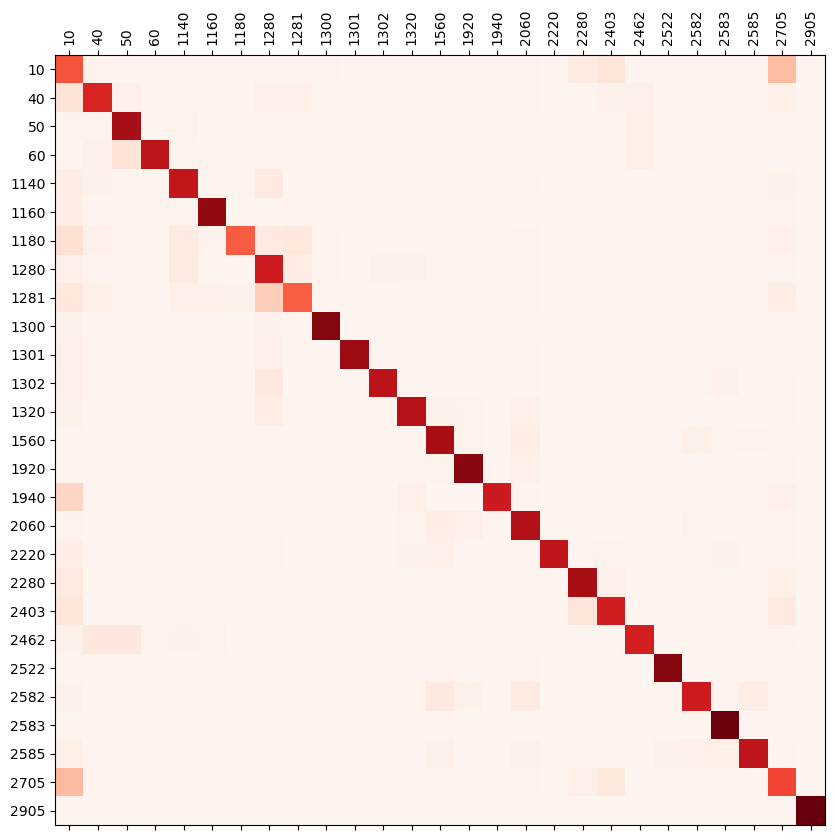

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
cm_normalized = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis])
#cm_normalized=cm.div(cm.sum(axis=1), axis=0)
cax = ax.matshow(cm_normalized, cmap='Reds')
plt.xticks(range(27),catdict,rotation=90)
plt.yticks(range(27),catdict,rotation=0)
plt.show()

## Etude des catégories 10 ; 2280 ; 2403 ; 2705

In [ ]:
df_livres=df_test[df_test['prdtypecode'].isin([10,2280,2403,2705])]
vectorizer=text_clf.named_steps['tfidf']

In [ ]:
df_livres.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3389 entries, 3 to 18679
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   3389 non-null   int64 
 1   designation  3389 non-null   object
 2   description  569 non-null    object
 3   productid    3389 non-null   int64 
 4   imageid      3389 non-null   int64 
 5   prdtypecode  3389 non-null   int64 
 6   predict      3389 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 211.8+ KB


In [ ]:

for c in [10,2280,2403,2705]:
    print(c,'   ------   ', catdict[c] )
    print(df_livres[df_livres['prdtypecode']==c]['predict'].value_counts(normalize=True)[:5])

10    ------    livres
10      0.551825
2705    0.240876
2403    0.089051
2280    0.061314
40      0.017518
Name: predict, dtype: float64
2280    ------    magazines
2280    0.851958
10      0.064947
2705    0.036294
2403    0.034384
1160    0.002865
Name: predict, dtype: float64
2403    ------    livres et bds
2403    0.722857
2280    0.086667
10      0.086667
2705    0.061905
2522    0.007619
Name: predict, dtype: float64
2705    ------    bds et livres
2705    0.591433
10      0.248764
2403    0.072488
2280    0.028007
40      0.014827
Name: predict, dtype: float64


In [ ]:
Words = vectorizer.transform(df_livres['designation'])
#help(CountVectorizer)
words = vectorizer.get_feature_names_out()
word_counts = Words.sum(axis=0)
word_count_dict = dict(zip(words, word_counts.tolist()[0]))
#print(word_count_dict)
occurrences_triees = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)[:80]
Dic_words={}
for item in occurrences_triees:
    #print(item[0], ":", item[1])
    Dic_words[item[0]]=item[1]
#print(Dic_words)
df_words=pd.DataFrame.from_dict(Dic_words, orient='index',columns=['Total'])
print(df_words.head(10))
print(df_words.tail())

               Total
n°        196.110676
lot        93.525068
livres     54.353834
tome       52.523236
france     34.460973
magazine   31.680565
revue      31.071815
vie        31.005727
histoire   26.751253
tomes      26.416442
              Total
nouvelles  6.513075
figaro     6.512966
éditions   6.478503
poche      6.447930
entre      6.436951


In [ ]:
df_total_livres=df_words
words = vectorizer.get_feature_names_out()
for c in [10,2705,2280,2403]:
    X_words = vectorizer.transform(df_livres[df_livres['prdtypecode']==c] ['designation'])
    word_counts = X_words.sum(axis=0)
    word_count_dict = dict(zip(words, word_counts.tolist()[0]))
    occurrences_triees = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)[:20]
    Dic_words={}
    for item in occurrences_triees:
        Dic_words[item[0]]=item[1]
    df_words_X=pd.DataFrame.from_dict(Dic_words, orient='index',columns=[str(c)])
    df_total_livres=df_total_livres.join(df_words_X)
df_total_livres.head(20)

,Total,10,2705,2280,2403
n°,196.110676,6.387835,NaN,154.293219,34.689318
lot,93.525068,NaN,NaN,NaN,92.307589
livres,54.353834,NaN,NaN,NaN,52.444013
tome,52.523236,10.606242,20.563485,NaN,19.862903
france,34.460973,3.963249,NaN,17.931244,10.770986
magazine,31.680565,NaN,NaN,22.560119,NaN
revue,31.071815,NaN,NaN,17.339068,12.661148
vie,31.005727,4.240766,9.877812,11.786411,NaN
histoire,26.751253,6.132431,NaN,5.693746,12.692732
tomes,26.416442,NaN,NaN,NaN,25.576526


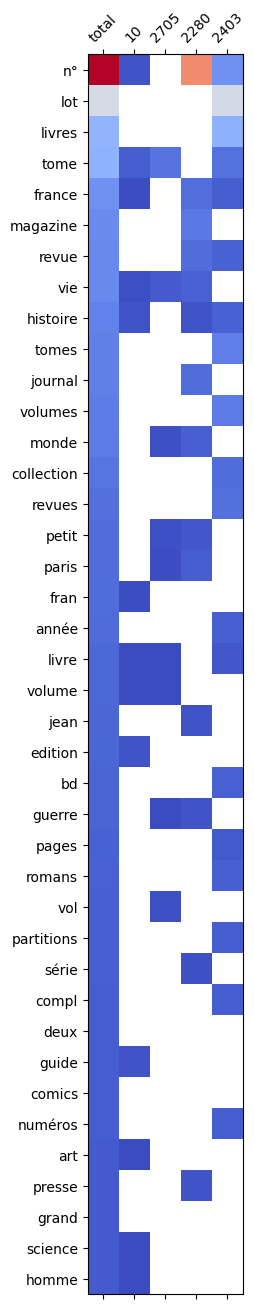

In [ ]:
fig, ax = plt.subplots(figsize=(2,20))
cax = ax.matshow(df_total_livres.iloc[0:40], cmap = 'coolwarm')
plt.xticks(range(5),('total','10','2705','2280','2403'),rotation=45)
plt.yticks(range(40),df_total_livres.iloc[0:40].index,rotation=0)
plt.show()


## Etude des catégories 1280,1281

In [ ]:
df_jouets=df_test[df_test['prdtypecode'].isin([1280,1281])]

In [ ]:
Words = vectorizer.transform(df_jouets['designation'])
#help(CountVectorizer)
words = vectorizer.get_feature_names_out()
word_counts = Words.sum(axis=0)
word_count_dict = dict(zip(words, word_counts.tolist()[0]))
#print(word_count_dict)
occurrences_triees = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)[:80]
Dic_words={}
for item in occurrences_triees:
    #print(item[0], ":", item[1])
    Dic_words[item[0]]=item[1]
#print(Dic_words)
df_words=pd.DataFrame.from_dict(Dic_words, orient='index',columns=['Total'])
print(df_words.head(10))
print(df_words.tail())

             Total
enfants  48.981541
jouet    40.659735
jouets   34.755548
peluche  33.297319
toy      32.485393
doudou   28.260545
puzzle   26.458930
jeu      24.249117
cadeau   23.870592
rc       21.159840
          Total
mavic  5.900924
lego   5.883192
dr     5.832703
ml     5.746969
card   5.731941


In [ ]:
df_total_jouets=df_words
words = vectorizer.get_feature_names_out()
for c in [1280,1281]:
    X_words = vectorizer.transform(df_jouets[df_jouets['prdtypecode']==c] ['designation'])
    word_counts = X_words.sum(axis=0)
    word_count_dict = dict(zip(words, word_counts.tolist()[0]))
    occurrences_triees = sorted(word_count_dict.items(), key=lambda x: x[1], reverse=True)[:20]
    Dic_words={}
    for item in occurrences_triees:
        Dic_words[item[0]]=item[1]
    df_words_X=pd.DataFrame.from_dict(Dic_words, orient='index',columns=[str(c)])
    df_total_jouets=df_total_jouets.join(df_words_X)
df_total_jouets.head(20)

,Total,1280,1281
enfants,48.981541,35.622105,13.359436
jouet,40.659735,32.363775,8.295960
jouets,34.755548,25.912372,8.843176
peluche,33.297319,30.849549,NaN
toy,32.485393,22.317277,10.168116
doudou,28.260545,28.260545,NaN
puzzle,26.458930,22.454506,NaN
jeu,24.249117,NaN,19.568103
cadeau,23.870592,17.702460,6.168132
rc,21.159840,20.114303,NaN


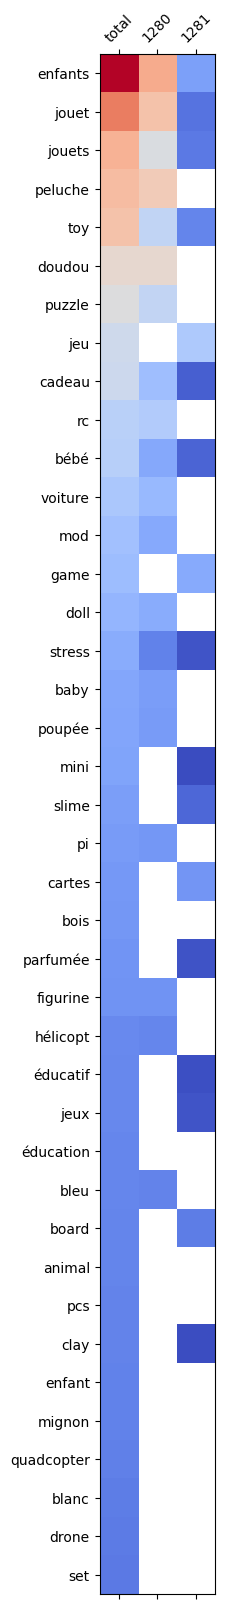

In [ ]:
fig, ax = plt.subplots(figsize=(2,20))
cax = ax.matshow(df_total_jouets.iloc[0:40], cmap = 'coolwarm')
plt.xticks(range(3),('total','1280','1281'),rotation=45)
plt.yticks(range(40),df_total_jouets.iloc[0:40].index,rotation=0)
plt.show()